# Monthly anomaly

This script allows user to compute anomaly on given period (months and years) using the full Sentinel 2 or Landsat 5,7,8 imagery based on user defined baseline (years).

The following workflow is applied:
1. Extract a mini dataset for selected area and month
1. Apply a mask
1. Split the dataset in two (baseline, period of anomaly calculation)
1. Apply mathematical expression & calculate means
1. Calculate anomaly the inverse way of CEOS ((example: selected - baseline) / baseline)
1. Compute quality and add it to dataset_out

### Main input parameters:

- **byears**: years to compute baseline
- **anom_years** & **anom_months**: years and months to compute anomaly (mean compared with mean of baseline scenes for the selected month)
- **bands**: bands needed by the mathematical expression
- **math_expr**: mathematical expression to apply on **bands**
- **cat_band**: band containing the classification (either *slc* or *cf_mask* for respectively Sentinel 2 or Landsat products
- **keep_cats**: categories of cat_band considered as data (see table below)
- **chunk_size** = chunk area (benchmark showed 0.15 is the best value (in used hardware) in the case of a 2 bands expression)
- **dis_range**: values range to display (to be zero centered it has to be symetrical) on figures
- **logname**: log name (used by *printanlog* function)
- **user_mail**: User mail (to be filled in the case the user need to be informed by email on process completion)

![](diagrams/documentation/mask_bands_table.png)

For example
- using **cat_band = 'slc'** with **keep_cats = [4]** with Sentinel 2 will compute the anomaly on pixel classified as vegetated only (see below figure with French Geoportail Ortophoto as a background).
- using **cat_band = 'cf_mask'** with **keep_cats = [0]** with Landsat will compute the anomaly on pixel classified as clear only.

![](diagrams/documentation/s2_monthly_anomaly_veg_only.png)

For more details see *Configuration* section and *expr_anom* function below


### Output:
- Percentage of change (anomaly)
- Output quality (percentage of pixel with data (through time) baseline * selected)

![](diagrams/documentation/monthy_anomaly_figures.png)

Outputs are available as

- geotiff (full dataset, integer format using "deflate" compression (*compress="deflate" added to utils/dc_utilities.py write_geotiff_from_xr*))
- figures (in script): maps & histograms (restricted to **dis_range** values)

### Goodies:
This script is the first implementation of *[printandlog](https://github.com/GRIDgva/SwissDataCube/wiki/printandlog)* function. Each time the function is used it will print a message on the notebook, an write it in a log file defined by **logname**.

A *.COMPLETED* file will also be generated containing the processing time (see *Inform processing completion* section).

Finally, if the **user_mail** parameter is filled, an email will be send containing the log file and the processing time.

In [1]:
# Import dependencies
%matplotlib inline

import os
from datetime import datetime
from matplotlib import colors
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import socket # gethostname

import datacube
import utils.dc_mosaic
from utils.dc_chunker import create_geographic_chunks, combine_geographic_chunks

from swiss_utils.sdc_utilities import easy_map, easy_export, printandlog

dc = datacube.Datacube()
api = datacube.api.API()

import warnings
warnings.simplefilter('ignore')

In [2]:
# LANDSAT 8 - Configuration section - 0.1° AOI
# AOI
platform = "LANDSAT_8"
product = "ls8_ledaps_swiss"
min_lon =  8.45
max_lon =  8.55
min_lat = 47.18
max_lat = 47.24
# TIME
base_years = [2014,2015]     # years for baseline computation
anom_years = [2016]          # years for anomaly computation
anom_months = [6,7,8]        # months for anomaly computation
# EXPRESSION
# bands and mathematical expression to apply (each band need "dataset_expr" prefix)
bands = ['red', 'nir']       # Bands to compute NDVI
math_expr = "(dataset_expr.nir - dataset_expr.red) / (dataset_expr.nir + dataset_expr.red)"
# PREFIXES
prfx_file = "ndvi_14-15_16_6-8"
prfx_fig = "Landsat 8 - NDVI June-August 2016 (baseline 2014-2015)"

# mask band and data categories
cat_band = 'cf_mask'         # Band containing the classification, to be used to create the mask
keep_cats = [0]              # Categories of cat_band considered as data (vegetation)

chunk_size = 1.0             # Chunk area (not benchmarked with Landsat yet)
dis_range = [-20, 20]        # Values range to display (to be zero centered it has to be symetrical)

# Log stuff
logname = 'monthy_anomaly.log'
user_mail = ''

In [3]:
# SENTINEL 2 - Configuration section - 0.1° AOI
# AOI
platform = "SENTINEL_2"
product = "s2_l2a_10m_swiss"
min_lon =  6.88
max_lon =  6.98
min_lat = 45.45
max_lat = 45.54
# TIME
base_years = [2016,2017] # years for baseline computation
anom_years = [2018]      # years for anomaly computation
anom_months = [7, 8]        # months for anomaly computation
# EXPRESSION
# bands and mathematical expression to apply (each band need "dataset_expr" prefix)
bands = ['red', 'nir']   # Bands to compute NDVI
math_expr = "(dataset_expr.nir - dataset_expr.red) / (dataset_expr.nir + dataset_expr.red)"
# PREFIXES
prfx_file = "ndvi_16-17_18_8"
prfx_fig = "Sentinel 2 - NDVI August 2018 (baseline 2016-2017)"

# mask band and data categories
cat_band = 'slc'         # Band containing the classification, to be used to create the mask
keep_cats = [4]          # Categories of cat_band considered as data (vegetation)

chunk_size = 0.15        # Chunk area
dis_range = [-20, 20]    # Values range to display (to be zero centered it has to be symetrical)

# Log stuff
logname = 'monthy_anomaly.log'
user_mail = ''

In [4]:
# Display AOI (OPTIONAL)
from utils.dc_display_map import display_map
display_map(latitude = (min_lat, max_lat), longitude = (min_lon, max_lon))

# Functions

In [5]:
# Function to convert a tupple to a condition
# Workaround as xa.apply_ufunc is not implemented in this version (0.9.6) of xarray
def tupple_to_cond(cats):
    for m in range(1,len(cats)+1):
        if m == 1: cond_cats = '(cat_arr == %i)' % (cats[m-1])
        else: cond_cats = '%s | (cat_arr == %i)' % (cond_cats, cats[m-1])
    return cond_cats

In [6]:
def expr_anom(plat, prod, expr, bands_expr, mask, data_cats, byears, years, months, lon, lat):
    """
    Description:
      Compute anomaly between a baseline (mean of all available scene for a given month)
      and a selected month (mean value as well) after the application of a given methematical
      expression such as calculation of NDVI.
    -----
    Input:
      plat: DC platform
      prod: DC product
      expr: mathematic expression to apply on bands (need dataset_expr prefix for each band)
      bands_expr: bands used in the expr
      mask_band: classified band to mask nodata
      data_cats: categories considered as containing data in mask_band
      byears: selected years for baseline computation
      years: selected years for anomaly computation
      months: selected months for anomaly computation
      lon: longitude (min, max)
      lat: latitude (min, max)
    Output:
      a single dataset (dataset out) containing 2 layers
        - pc_change: anomaly in percent ((selected monts/years - baseline) / baseline)
        - qual: quality (percentage of pixel with data,  baseline * selected )
    """

    # add mask band if necessary
    if mask not in bands_expr: bands_expr = bands_expr + [mask,]

    # 1.Extract a mini dataset for selected area and months
    # Get a Mini Data Cube
    dataset_in = dc.load(platform=plat,
                         product=prod,
                         lon=lon,
                         lat=lat,
                         measurements=bands_expr)
    # Filter by selected months
    dataset_in = dataset_in.sel(time=np.isin(dataset_in['time.month'], months))

    # 2.Apply a mask
    # Create mask
    cat_arr = dataset_in[mask]
    clean_mask = eval(tupple_to_cond(data_cats))
    # Remove unecessary stuff
    del cat_arr
    dataset_in = dataset_in.drop(mask)
    # Apply the mask
    dataset_in = dataset_in.where(clean_mask)
    
    # 3. Baseline: extract selected years & calculate mean
    # Filter by selected years
    dataset_expr = dataset_in.sel(time=np.isin(dataset_in['time.year'], byears))
    clean_expr = clean_mask.sel(time=np.isin(clean_mask['time.year'], byears))
    # Calculate baseline data completness
    data_pc_baseline = clean_expr.where(clean_expr).sum('time') / len(clean_expr)

    # 4. Apply mathematical expression to all dates & calculate mean (to be used as baseline)
    expr_scenes = eval(expr)
    expr_baseline = expr_scenes.mean(dim='time', skipna=True, keep_attrs=False)

    # 5. Anomaly: extract selected years & calculate mean
    # Filter by selected years
    dataset_expr = dataset_in.sel(time=np.isin(dataset_in['time.year'], years))
    del dataset_in
    clean_expr = clean_mask.sel(time=np.isin(clean_mask['time.year'], years))
    del clean_mask
    expr_scenes = eval(expr)
    expr_scene = expr_scenes.mean(dim='time', skipna=True, keep_attrs=False)
    # Calculate selected years data completness
    data_pc_scene = clean_expr.where(clean_expr).sum('time') / len(clean_expr)
    del clean_expr

    # 6.Calculate anomaly the inverse way of CEOS example ((selected - baseline) / baseline)
    percentage_change = np.rint((expr_scene - expr_baseline) / expr_baseline * 100).astype(rasterio.int16)
    del expr_baseline
    del expr_scene
    dataset_out = percentage_change.to_dataset(name="pc_change")
    del percentage_change
    
    # 7. Compute quality and add it to dataset_out
    dataset_out['qual'] = np.rint(data_pc_baseline * data_pc_scene * 100).astype(rasterio.uint8)
    del data_pc_baseline
    del data_pc_scene
    
    # Fix nodata issues
    dataset_out['pc_change'] = dataset_out.pc_change.where(dataset_out.qual != 0)
    dataset_out['qual'] = dataset_out.qual.where(dataset_out.qual != 0)
    
    return dataset_out

In [7]:
# Compute anomaly
time_start = datetime.now()
printandlog('STARTED computing anomaly', logname, reset = True)

if ((max_lon - min_lon) * (max_lat - min_lat) <= chunk_size):
    # Compute anomaly at once
    printandlog('Processing all at once', logname)
    anom = expr_anom(platform, product,math_expr, bands, cat_band, keep_cats,
                     base_years, anom_years, anom_months, (min_lon, max_lon), (min_lat, max_lat))
else:
    # Compute anomaly by chunk
    # Cut the geographic extents into chunks
    geographic_chunks = create_geographic_chunks(latitude=(min_lat, max_lat), longitude=(min_lon, max_lon), geographic_chunk_size=chunk_size)
    # Loop through chunks
    cnt = 0
    chunks_nb = len(geographic_chunks)
    product_chunks = []
    for index, chunk in enumerate(geographic_chunks):
        cnt += 1
        printandlog('Chunk %i/%i' % (cnt, chunks_nb), logname)
        pc_change = expr_anom(platform, product,math_expr, bands, cat_band, keep_cats,
                              base_years, anom_years, anom_months, chunk['longitude'], chunk['latitude'])
        # Append result
        product_chunks.append(pc_change)
        # Combine chunks 
    anom = combine_geographic_chunks(product_chunks)
    
printandlog('Anomaly computed in %s' % (datetime.now()-time_start), logname)

2018-10-19 10:20:24.032339 | STARTED computing anomaly
2018-10-19 10:20:24.032860 | Processing all at once
2018-10-19 10:20:42.836841 | Anomaly computed in 0:00:18.804911


2018-10-19 10:20:42.856562 | Export anom_pc and create figures


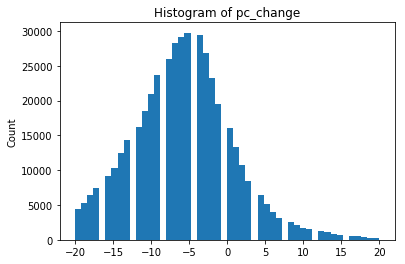

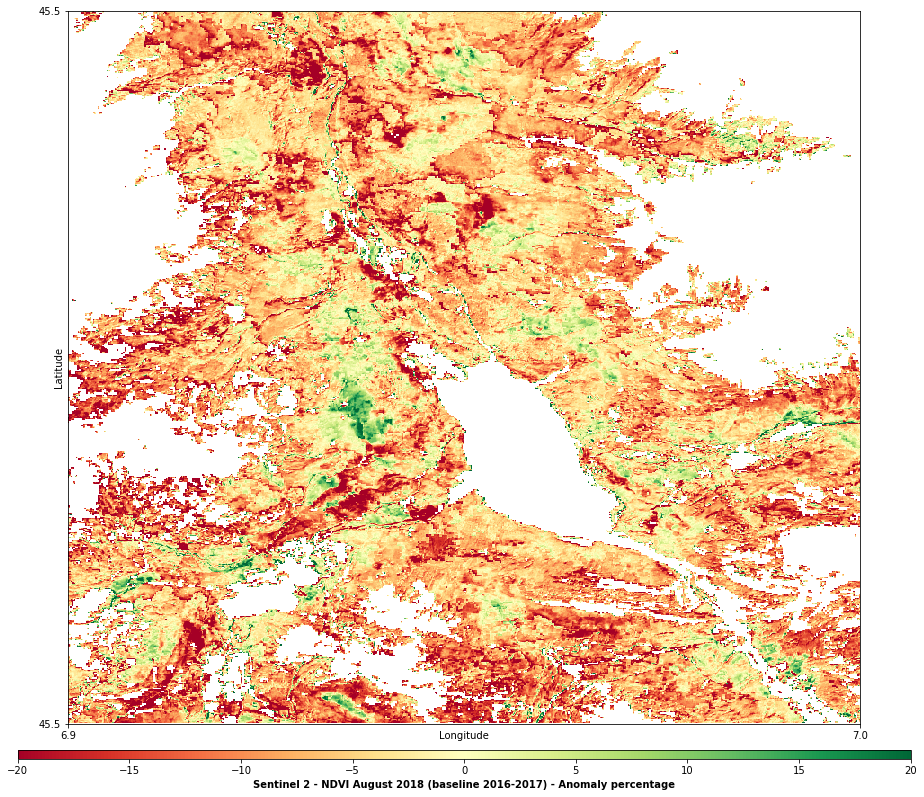

In [8]:
# anom_pc output

printandlog('Export anom_pc and create figures', logname)

# Export to NETCDF
easy_export(anom.pc_change, "%s_anom_pc" % (prfx_file), "nc")

# Plot histogram
anom.pc_change.plot.hist(bins=50, range=dis_range)
plt.savefig("%s_anom_pc_histo.png" % (prfx_file), bbox_inches='tight')

# Constrains values range for display
anom.pc_change.values[anom.pc_change < dis_range[0]] = dis_range[0]
anom.pc_change.values[anom.pc_change > dis_range[1]] = dis_range[1]

# Preview a specific scenes and band
easy_map(anom.pc_change, 'RdYlGn', '%s - Anomaly percentage' % (prfx_fig), 16)
plt.savefig("%s_anom_pc_map.png" % (prfx_file), bbox_inches='tight')

2018-10-19 10:20:44.888642 | Export anom_qual and create figures


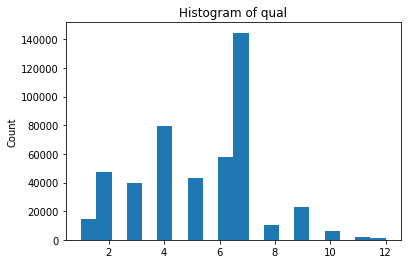

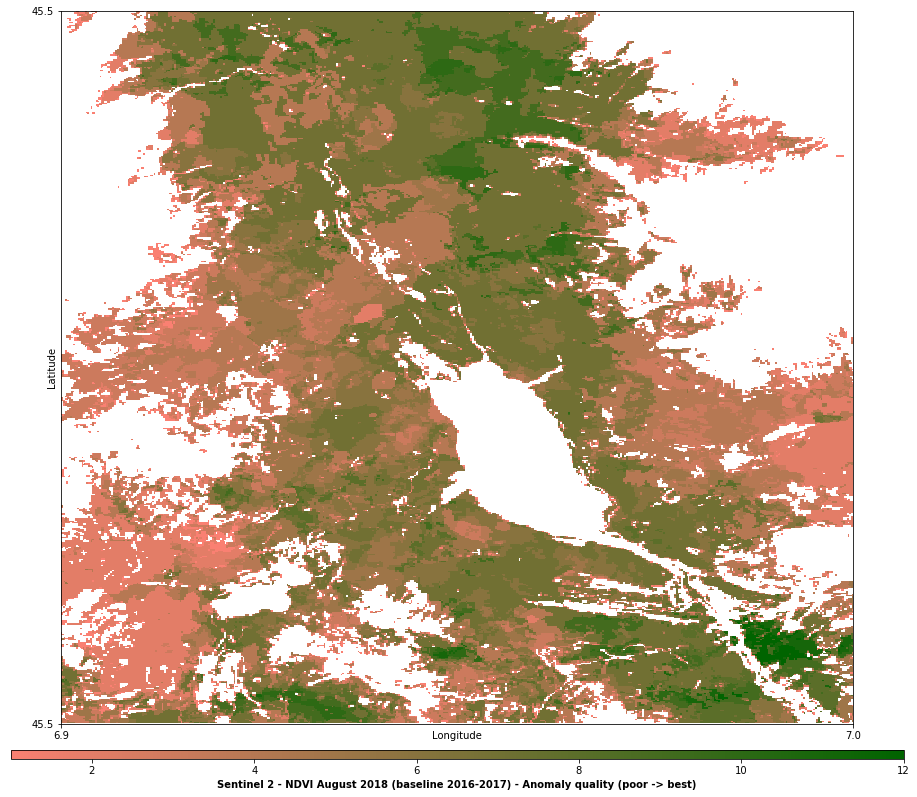

In [9]:
# anom_qual output

printandlog('Export anom_qual and create figures', logname)

# Export to NETCDF
easy_export(anom.qual, "%s_anom_qual" % (prfx_file), "nc")

# Compute histogram
anom.qual.plot.hist(bins=20)
plt.savefig("%s_anom_qual_histo.png" % (prfx_file), bbox_inches='tight')

# OPTIONAL - Preview a specific scenes and band
easy_map(anom.qual,
         colors.LinearSegmentedColormap.from_list('RdGn', ['salmon','darkgreen'], N=256),
         '%s - Anomaly quality (poor -> best)' % (prfx_fig),
         16)
plt.savefig("%s_anom_qual_map.png" % (prfx_file), bbox_inches='tight')

In [10]:
# Inform processing completion

proces_time = datetime.now()-time_start
printandlog('DONE in %s' % (proces_time), logname)
# Write a .COMPLETED file
with open(logname.replace('.log', '.COMPLETED'), 'w') as file:
    file.write('DONE in %s' % (proces_time))
# Send a completion email with log as attachement if required
if user_mail != '':
    os.system("echo 'DONE in %s' | mail -s '%s script on %s' -A %s %s" %
              (proces_time, logname.replace('.log', ''), socket.gethostname(), logname, user_mail))

2018-10-19 10:20:46.323543 | DONE in 0:00:22.291605
